In [1]:
import json
from pathlib import Path
from datetime import timedelta

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
input_data = list(Path("../matched-infoboxes-extracted/").rglob("*.json"))
files = [x for x in input_data if x.is_file()]
len(files) 

586

In [3]:
num_edits = 0
change_tuples = []
for file in tqdm(files[:50]):
    with open(file, 'r', encoding='utf-8') as f:
        for jsonObj in f:
            single_edit = json.loads(jsonObj)
            num_edits += 1
            #entries.append(single_edit)
            key = single_edit['key'] # is needed as there could be multiple infoboxes on the same page which could change at the same time
            title = single_edit['pageTitle']#['key']
            changes = single_edit['changes']
            timestamp = single_edit['validFrom']
            for change in changes:
                name = change['property']['name']
                current_value = change['currentValue'] if 'currentValue' in change.keys() else None
                previous_value = change['previousValue'] if 'previousValue' in change.keys() else None
                change_tuples.append((key, title, name, previous_value, current_value, timestamp))
print(num_edits) # 1934309 for 50
len(change_tuples) # 9715201 for 50

  0%|          | 0/50 [00:00<?, ?it/s]

5016110


22807979

In [4]:
data = pd.DataFrame(change_tuples, columns=['key', 'title', 'name', 'previous_value', 'current_value', 'timestamp'])
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [27]:
data.shape[0]

22807979

Number of times the same infobox was changed at the same second

In [6]:
len(data[['key', 'title', 'name', 'timestamp']]) - len(data[['key', 'title', 'name', 'timestamp']].drop_duplicates()) 

1004

--> Can be ignored as it is so low

## Filter out creations and deletions

In [11]:
#Creations
data[data['previous_value'].isna()].shape[0]

3194532

In [8]:
#Deletions
data[data['current_value'].isna()].shape[0]

2996504

--> About three quarters of the changes of the subset are creational or deletional changes

In [93]:
data = data.dropna(subset=['previous_value','current_value'])

In [6]:
data.shape[0]

18118106

## Look at popular properties 

In [55]:
changes_per_property = data['name'].value_counts()

In [56]:
changes_per_property[:30]

image          382563
name           296450
template       228672
caption        197057
genre          184228
birth_date     125568
birth_place    117947
released       105716
website         87570
pcupdate        84870
currentclub     66964
occupation      66706
country         63423
type            62697
starring        58246
producer        57024
death_date      53837
position        53649
label           53644
location        51863
spouse          51633
caps(goals)     48481
nickname        47510
height          45585
reviews         44870
clubnumber      43946
death_place     41107
writer          40054
next album      39673
years           39119
Name: name, dtype: int64

## Analyze number of changes per key

In [37]:
changes_per_key = data['key'].value_counts()

In [17]:
changes_per_key

100170704-0    11821
9022080-0       6087
45647758-0      4494
133467261-0     4493
25597471-0      4208
               ...  
441686297-2        1
468323715-2        1
82060526-2         1
366096823-1        1
79873547-0         1
Name: key, Length: 9570, dtype: int64

In [18]:
frequ_of_changes = changes_per_key.value_counts()

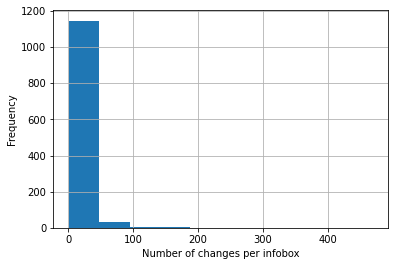

In [19]:
frequ_of_changes.hist(bins=10)
plt.xlabel("Number of changes per infobox")
plt.ylabel("Frequency")
plt.show()

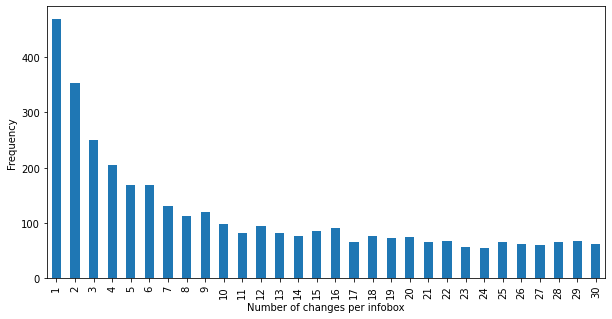

In [20]:
frequ_of_changes.sort_index(ascending=True)[:30].plot.bar(figsize=(10,5))
plt.xlabel("Number of changes per infobox")
plt.ylabel("Frequency")
plt.show()

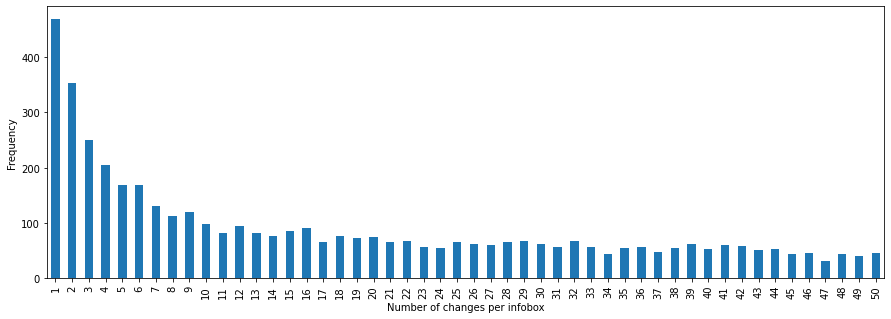

In [21]:
frequ_of_changes.sort_index(ascending=True)[:50].plot.bar(figsize=(15,5))
plt.xlabel("Number of changes per infobox")
plt.ylabel("Frequency")
plt.show()

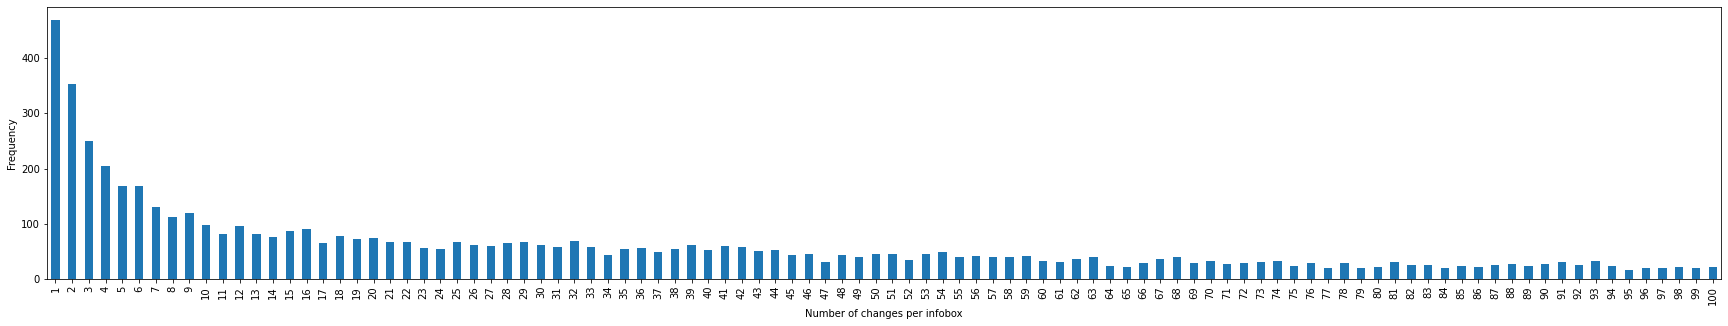

In [22]:
frequ_of_changes.sort_index(ascending=True)[:100].plot.bar(figsize=(30,5))
plt.xlabel("Number of changes per infobox")
plt.ylabel("Frequency")
plt.show()

In [23]:
frequ_of_changes.sort_index(ascending=False)[:20]

11821    1
6087     1
4494     1
4493     1
4208     1
4026     1
3858     1
3816     1
3757     1
3458     1
3419     1
3416     1
3390     1
3365     1
3346     1
3281     1
3277     1
3274     1
3167     1
3124     1
Name: key, dtype: int64

## What is a good threshold? How many changes should be our minimum to make reliable predictions?

Start with at least 100 changes

In [38]:
changes_per_key_many_changes = changes_per_key[changes_per_key>=100]

In [25]:
print('Only {} unique infoboxes left in the subset.'.format(changes_per_key_many_changes.shape[0]))

Only 3614 unique infoboxes left in the subset.


In [39]:
data = data[data['key'].isin(changes_per_key_many_changes.index)]

In [27]:
data

,key,title,name,previous_value,current_value,timestamp
364,11977384-0,Australian Democrats,ideology,[[liberalism|social liberal]],Social [[Liberalism]],2005-07-04 22:29:15+00:00
365,11977384-0,Australian Democrats,ideology,Social [[Liberalism]],[[liberalism|social liberal]],2005-07-05 00:56:54+00:00
366,11977384-0,Australian Democrats,template,infobox_political_party,infobox_australian_political_party,2005-09-23 07:26:21+00:00
368,11977384-0,Australian Democrats,party_logo,[[Image:Australiandemocratlogo.gif]],[[Image:Ausdem_newlogo.JPG|200px]],2005-10-15 06:06:44+00:00
369,11977384-0,Australian Democrats,foundation,[[1977]],1977,2005-12-17 13:54:59+00:00
...,...,...,...,...,...,...
8087081,65523991-0,Cameron Diaz,years_active,1994–2014,1990–2014,2019-07-30 15:28:45+00:00
8087082,65523991-0,Cameron Diaz,occupation,"Retired actress, writer, former model","Artist, actress, writer, former model",2019-08-11 05:22:26+00:00
8087083,65523991-0,Cameron Diaz,years_active,1990–2014,1990–2016,2019-08-25 01:25:27+00:00
8087084,65523991-0,Cameron Diaz,occupation,"Artist, actress, writer, former model",{{hlist|Artist|actress|writer|former model}},2019-08-30 02:56:02+00:00


## Look at changes per (key, propertyName) tuple

In [14]:
changes_per_key_and_name = data[['key','name']].value_counts()

In [15]:
changes_per_key_and_name

key          name           
118964357-0  num_episodes       2962
37799480-0   genre              1595
528594712-0  current_members    1315
95362092-0   judges             1077
321925250-0  num_episodes        781
                                ... 
61370503-0   term_end              1
             template              1
300431242-0  released              1
             template              1
100002730-0  coordinates           1
Length: 2130670, dtype: int64

In [21]:
changes_per_key_and_name[:50]

key          name                
118964357-0  num_episodes            2962
37799480-0   genre                   1595
528594712-0  current_members         1315
95362092-0   judges                  1077
321925250-0  num_episodes             781
24291635-0   genre                    770
127788329-0  gross                    762
72362254-0   current champions        678
31536085-0   genre                    676
89677820-0   misc                     664
37149965-0   result                   658
173468547-0  incumbent                654
19402539-3   name                     653
269976299-0  awards                   638
57793854-0   updated                  638
545084225-0  ideology                 621
628311504-0  num_episodes             592
57793854-0   singlesrecord            586
90429869-0   currentclub              586
40487670-0   nickname                 564
504878331-0  starring                 556
134131257-0  years                    556
212998861-0  type                     552


Filter out combinations with <100 changes again

In [16]:
changes_per_key_and_name_many_changes  = changes_per_key_and_name[changes_per_key_and_name>=100]

In [17]:
print('Only {} unique (infobox, property) combinations left in the subset.'.format(changes_per_key_and_name_many_changes.shape[0]))

Only 2327 unique (infobox, property) combinations left in the subset.


In [18]:
data = data[data[['key','name']].apply(tuple, axis=1).isin(changes_per_key_and_name_many_changes.index)]

In [19]:
data.shape[0]

387096

## Investigate regularly changing properties

In [35]:
data[data['name']=='born']

,key,title,name,previous_value,current_value,timestamp
17227,166646306-0,Hope Williams Brady,born,,"[[December 24]], [[1974]]) (onscreen; SORASed ...",2007-10-28 19:04:36+00:00
17228,166646306-0,Hope Williams Brady,born,"[[December 24]], [[1974]]) (onscreen; SORASed ...","Onscreen [[December 24]], [[1974]]",2007-10-29 12:48:03+00:00
17263,166646306-0,Hope Williams Brady,born,"Onscreen [[December 24]], [[1974]]","Onscreen December 24, 1974",2008-11-07 15:00:41+00:00
17295,166646306-0,Hope Williams Brady,born,"Onscreen December 24, 1974","Onscreen January 10, 1974 (orginial)<br> Decem...",2009-06-19 17:13:53+00:00
17384,166646306-0,Hope Williams Brady,born,"Onscreen January 10, 1974 (orginial)<br> Decem...","Onscreen January 10, 1974 (original)<br> Decem...",2011-01-26 02:54:28+00:00
...,...,...,...,...,...,...
22800707,368717948-0,Omar Musa,born,{{birth date|1984|1|09}} (age 25) <br /> [[Que...,{{birth date|1984|1|09}} (age 25) <br /> [[Que...,2010-10-08 05:08:37+00:00
22800710,368717948-0,Omar Musa,born,{{birth date|1984|1|09}} (age 25) <br /> [[Que...,{{birth date and age|1984|1|09}} <br /> [[Que...,2011-03-14 10:28:31+00:00
22800711,368717948-0,Omar Musa,born,{{birth date and age|1984|1|09}} <br /> [[Que...,{{birth date and age|df=yes|1984|1|09}} <br /...,2011-07-22 02:55:05+00:00
22803876,367292223-0,Dylan Mattingly,born,"March 18th, 1991",1991,2010-06-11 20:57:37+00:00


In [49]:
data[data['name']=='born']['key'].value_counts().value_counts()[:10]

1     990
2     538
3     275
4     186
5     118
6      84
7      73
8      55
9      29
10     25
Name: key, dtype: int64

Observation: Sometimes "born" refers to only the date of birth, but sometimes it includes the age of the person which needs to be updated regularly.
Apparently "Born" is  not a basic parameter and normally refers to a section of "birth_date", "birth_name", "birth_place

In [50]:
data[data['name']=='birth_name']['key'].value_counts().value_counts()[:10]

1     2509
2     1192
3      460
4      352
5      188
6      145
8       98
7       92
9       52
11      49
Name: key, dtype: int64

"Birth name" seems to be less prone to many changes, as it should be unambigous and stay the same, however there is a long tail to the frequency distribution.

In [60]:
data[data['name']=='birth_date']['key'].value_counts().value_counts()[:10]

1     19682
2      7781
3      3725
4      2001
5      1189
6       764
7       533
8       338
9       300
10      272
Name: key, dtype: int64

In [63]:
data[data['name']=='birth_place']['key'].value_counts().value_counts()[:10]

1     20377
2      8006
3      3856
4      2117
5      1223
6       796
7       539
8       374
9       301
10      234
Name: key, dtype: int64

"Birth date" and "birth place" are quite stable but again have a very long tails.

In [57]:
g = data[data['name']==property_name].groupby(['key','name'])

In [114]:
property_list = ['population', 'num_episodes', 'score', 'wins','losses', 'year']

Sort values after group by

In [ ]:
g.apply(lambda x: x['timestamp'].sort_values(ascending=True))

KeyboardInterrupt: 

In [82]:
bins = [
    pd.Timedelta(minutes = 0),
    pd.Timedelta(days = 1),
    pd.Timedelta(days = 7),
    pd.Timedelta(days = 30),
    pd.Timedelta(days = 356),
    pd.Timedelta(days = 712),
    pd.Timedelta(days = 1750),
    pd.Timedelta(days=35600)
]

In [83]:
labels = ['0-1day', '1-7days', '7-30days', '30-356days', '1-2years', '2-5years', '5years+']

In [34]:
avg_time_diff_pop = g.apply(lambda x: x['timestamp'].diff().mean())

In [35]:
avg_time_diff_pop

key          name      
100142209-0  population      405 days 18:07:38.200000
10026100-0   population             623 days 13:18:18
10026107-0   population             935 days 07:54:47
10026111-0   population             935 days 07:51:57
10026118-0   population   623 days 04:19:05.666666664
                                      ...            
98770238-0   population      208 days 09:25:00.100000
99099388-0   population            1364 days 19:09:51
9936565-0    population             693 days 20:15:25
99635527-0   population            3020 days 23:51:09
99872403-0   population                           NaT
Length: 8281, dtype: timedelta64[ns]

In [38]:
deltas = pd.cut(avg_time_diff_pop, bins, labels = labels)

<AxesSubplot:>

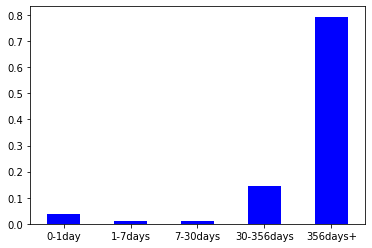

In [52]:
deltas.value_counts(normalize=True, sort=False).plot.bar(rot=0, color="b", figsize=(6,4), title='Property: {}'.format(property_name))

In [115]:
import math
def plot_time_to_changes(df, property_list):
    height = math.ceil(len(property_list) / 2)
    fig, axs = plt.subplots(height, 2, figsize=(16,16))
    
    for i,property_name in enumerate(property_list):
        g = data[data['name']==property_name].groupby(['key','name'])
        avg_time_diff = g.apply(lambda x: x['timestamp'].diff().median())
        deltas = pd.cut(avg_time_diff_pop, bins, labels = labels)
        binned_counts = deltas.value_counts(normalize=True, sort=False)
        
        axs[i//2, i%2].bar(binned_counts.index.astype(str), binned_counts.values)
        axs[i//2, i%2].set_title('Property: {}'.format(property_name))
        axs[i//2, i%2].set_ylabel('% of all changes of the property')
        axs[i//2, i%2].set_xlabel('Avg time until next change')
    plt.savefig('test.png')
    plt.show()
    

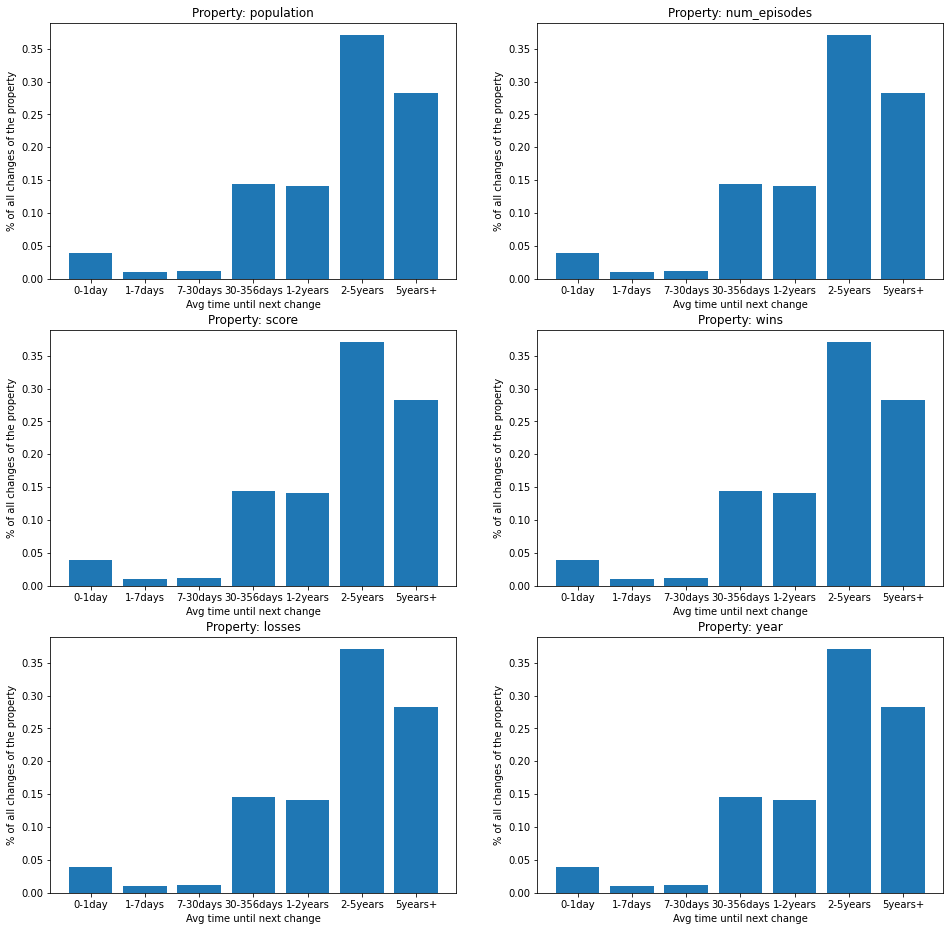

In [116]:
plot_time_to_changes(data,property_list)